# Parkinson disease classification

## 1. Data Preprocessing
> 1.1. Loading data <br /> 
> 1.2. Checking for missing values <br /> 
> 1.3. Outliers detection <br /> 
> 1.4. Basic data visulaizations <br /> 
>> 1.4.1. Correlation heatmap <br />
>> 1.4.2. Value counts <br />
>> 1.4.3. Skewness of features <br />
>
> 1.5. Log transform <br />

## 2. Modeling
> 2.1. Classifier selection <br />
> 2.2. Hyperparameters tuning <br />
>> 2.2.1. Nested Cross-validation
>
> 2.3. Learning curves <br />
> 2.4. Validation curves <br />
> 2.5. ROC curve and AUC <br />
> 2.6. Prediction <br />

## 3. Post-processing and final analysis
> 3.1. Confusion matrix <br />
> 3.2. Cost complexity pruning <br />

## 1. Data Preprocessing

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from OwnLibrary import IQR_technique
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1. Loading data

In [2]:
data = pd.read_csv("parkinsons.data")

# Moving labels column into the last spot as it is more convenience
temporary = data.status
data.drop(columns="status", inplace=True)
data = pd.concat([data, temporary], axis=1)

data.head()

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR      RPDE       DFA   spread1   spread2  \
0      0.06545  0.02211  21.033  0.414783  0.815285 -4.813031  0.266482   
1      0.09403  0.01929  19.085  0.458359  0.819521 -4.075192  0.335590   
2      0.08270  0.01309  20.651  0.429895  0.825288 -4.443179  0.311173   
3      0.08771  0.01353  20.644  0.434969  0.819235 -4.117501  0.334147   
4      0.10470  0.01767  19.649  0.417356  0.823484 -3.747787  0.234513   

         D2       PPE  status  
0  2.301442  0.284654       1  
1  2.486855  0.368674       1  
2  2.342259  0.332634       1  
3  2.405554  0.368975       1  
4  2.332180  0.410335       1  

[5 rows x 24 columns]

In [3]:
data.describe()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   
25%            0.000020    0.001660    0.001860    0.004985      0.016505   
50%            0.000030    0.002500    0.002690    0.007490      0.022970   
75%            0.000060    0.003835    0.003955    0.011505      0.037885   
max            0.000260    0.021440    0.019580    0.064330      0.119080   

       MDVP:Shimmer(dB)  ...  Shimmer:DDA         NHR         HNR        RPDE  \
count        195.000000  ...   195.000000  195.000000  195.000000  195.000000   
mean           0.282251  ...     0.046993    0.024847   21.885974    0.498536   
std            0.194877  ...     0.030459    0.040418    4.425764    0.103942   
min            0.085000  ...     0.013640    0.000650    8.441000    0.256570   
25%            0.148500  ...     0.024735    0.005925   19.198000    0.421306   
50%            0.221000  ...     0.038360    0.011660   22.085000    0.495954   
75%            0.350000  ...     0.060795    0.025640   25.075500    0.587562   
max            1.302000  ...     0.169420    0.314820   33.047000    0.685151   

              DFA     spread1     spread2          D2         PPE      status  
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000  
mean     0.718099   -5.684397    0.226510    2.381826    0.206552    0.753846  
std      0.055336    1.090208    0.083406    0.382799    0.090119    0.431878  
min      0.574282   -7.964984    0.006274    1.423287    0.044539    0.000000  
25%      0.674758   -6.450096    0.174351    2.099125    0.137451    1.000000  
50%      0.722254   -5.720868    0.218885    2.361532    0.194052    1.000000  
75%      0.761881   -5.046192    0.279234    2.636456    0.252980    1.000000  
max      0.825288   -2.434031    0.450493    3.671155    0.527367    1.000000  

[8 rows x 23 columns]

### 1.2. Checking for missing values

In [4]:
data.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
status              0
dtype: int64

### 1.3. Outliers detection
Outliers can have a significant effect on the whole process of predictions and data analysis, it is important to 
handle with them properly.

Firstly I decided to to visualize them on boxplots.

Then I decided to use the Tukey fences technique, which is based on interquartile range (IQR)

Text(0.5, 0.98, 'Boxplots to visualize outliers')

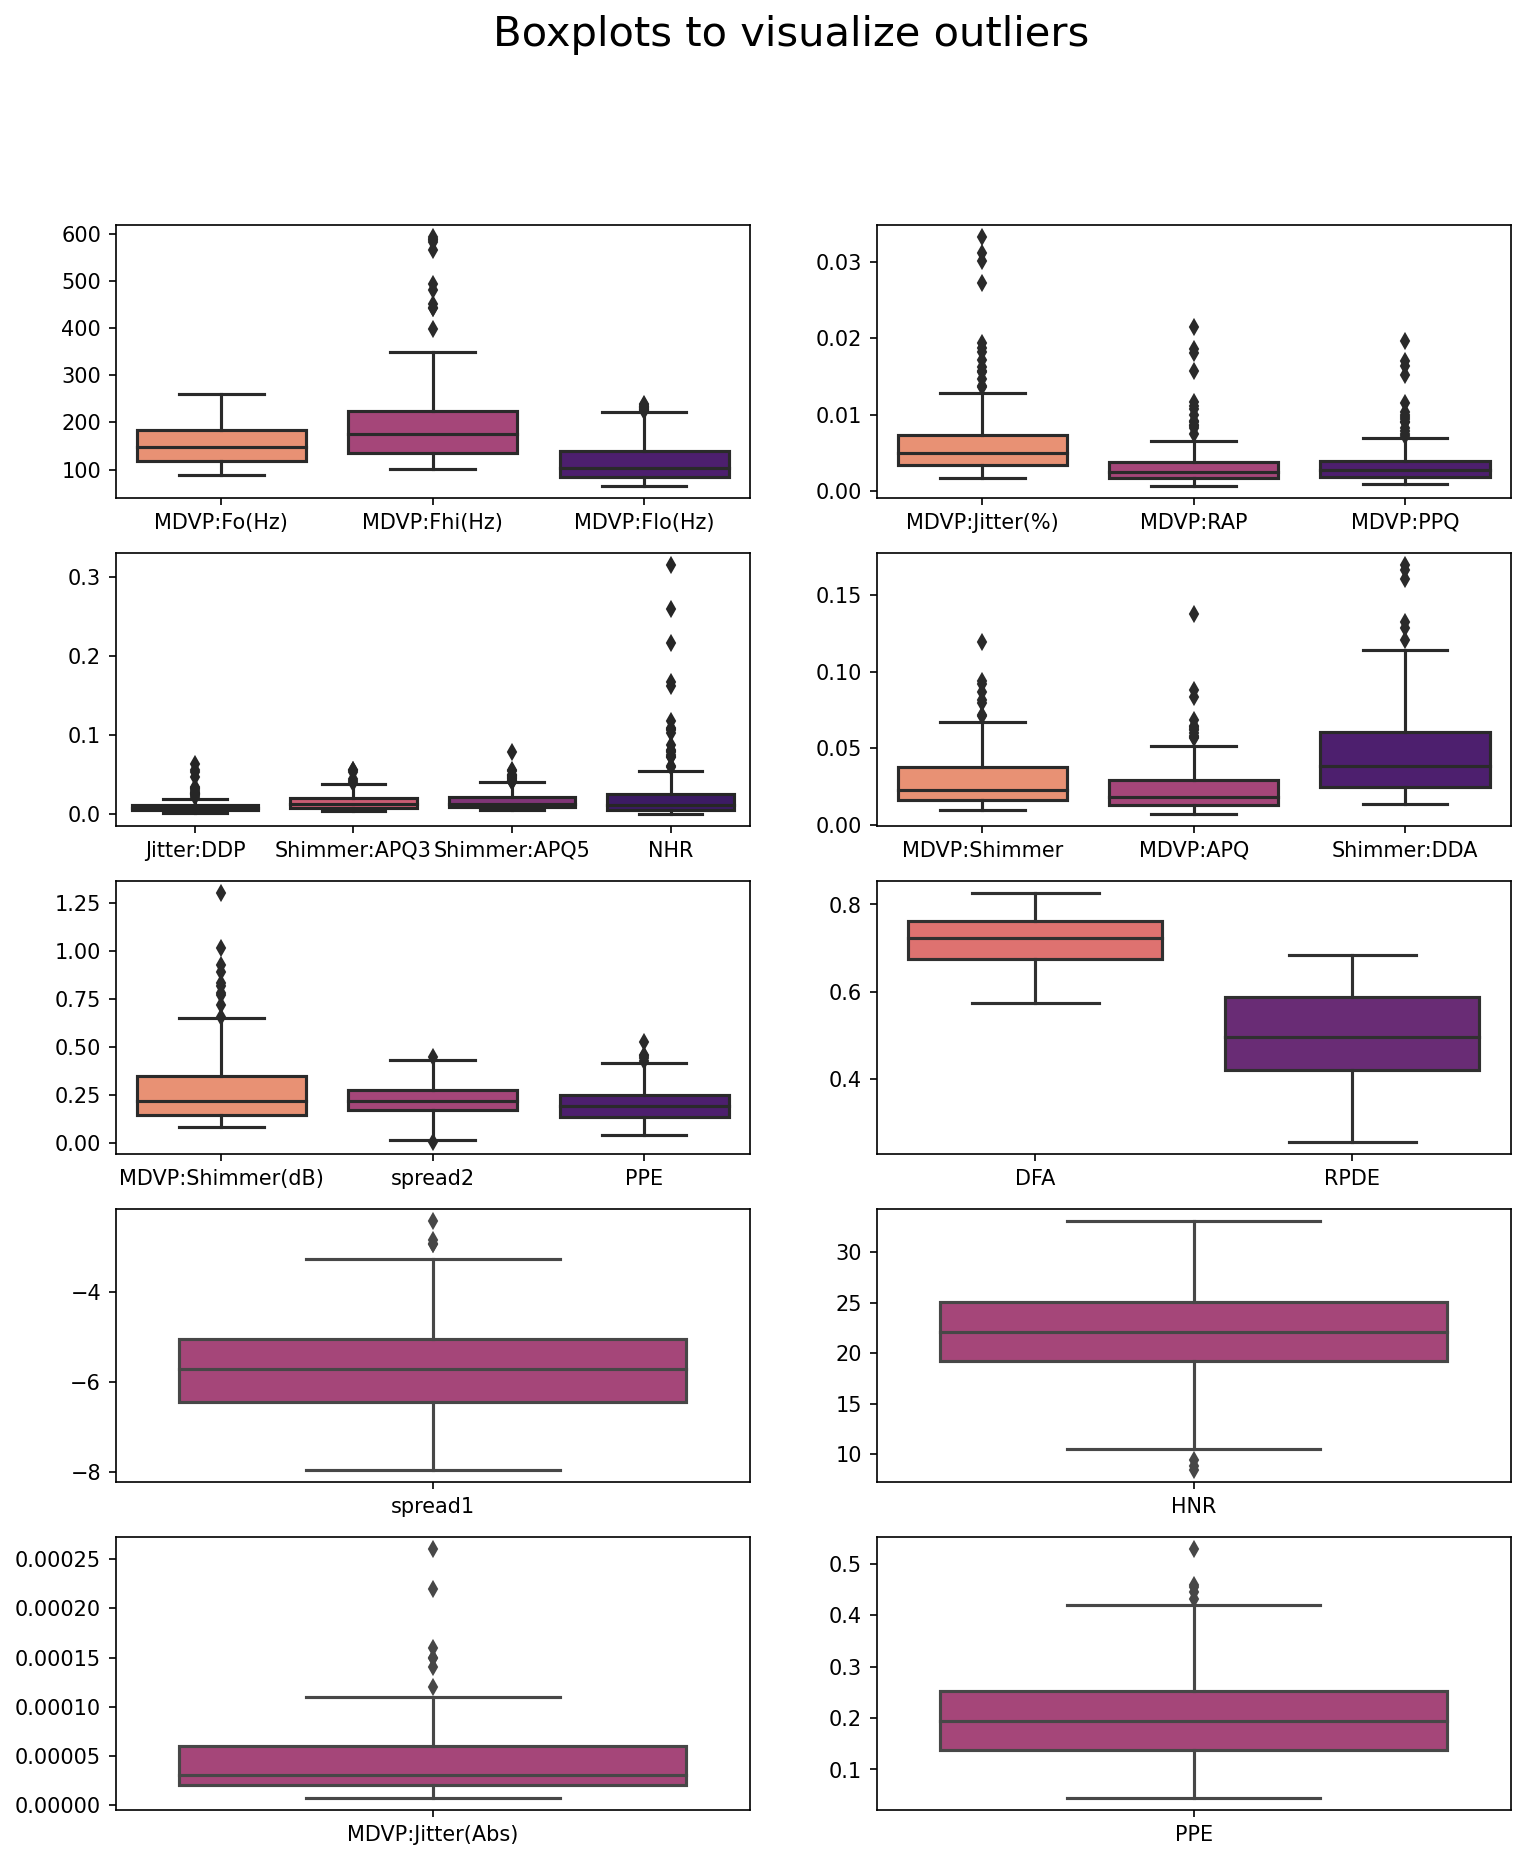

In [5]:
plt.figure(dpi=150, figsize=(12,14))

# Due to different ranges of the values for each feature I hard-coded them into each subplot for a good visualization

plt.subplot(5,2,1)
sns.boxplot(data=data[data.columns[0:4]], palette="magma_r")

plt.subplot(5,2,2)
sns.boxplot(data=data[["MDVP:Jitter(%)", "MDVP:RAP", "MDVP:PPQ"]], palette="magma_r")

plt.subplot(5,2,3)
sns.boxplot(data=data[["Jitter:DDP", "Shimmer:APQ3", "Shimmer:APQ5", "NHR"]], palette="magma_r")

plt.subplot(5,2,4)
sns.boxplot(data=data[["MDVP:Shimmer", "MDVP:APQ", "Shimmer:DDA"]], palette="magma_r")

plt.subplot(5,2,5)
sns.boxplot(data=data[["MDVP:Shimmer(dB)","spread2","PPE"]], palette="magma_r")

plt.subplot(5,2,6)
sns.boxplot(data=data[["DFA", "RPDE"]], palette="magma_r")

plt.subplot(5,2,7)
sns.boxplot(data=data[["spread1"]], palette="magma_r")

plt.subplot(5,2,8)
sns.boxplot(data=data[["HNR"]], palette="magma_r")

plt.subplot(5,2,9)
sns.boxplot(data=data[["MDVP:Jitter(Abs)"]], palette="magma_r")

plt.subplot(5,2,10)
sns.boxplot(data=data[["PPE"]], palette="magma_r")

plt.suptitle("Boxplots to visualize outliers", fontsize=20)

In [6]:
# Outliers are clearly visible, let's now use Tukey method to detect samples having multiple outliers

iqr = IQR_technique(data, 4, data.columns[1:23])
outliers_dict, multi_outliers = iqr.detect()

print(f"\nIndices with corrseponding amount of outliers:\n {outliers_dict}")
print(f"\nSamples having more than {iqr.min_outliers_number} outliers: {multi_outliers}")

# Some samples have a lot of outliers in different features, although as we are facing medical data, it is not so obvious
# to drop them off. Anyway it is nice to have them detected


Indices with corrseponding amount of outliers:
 Counter({151: 16, 152: 15, 102: 14, 100: 13, 149: 10, 146: 10, 148: 9, 99: 8, 150: 7, 101: 6, 147: 6, 157: 6, 91: 6, 98: 4, 97: 3, 115: 2, 193: 2, 192: 2, 4: 2, 141: 2, 90: 2, 89: 2, 17: 2, 73: 1, 116: 1, 117: 1, 118: 1, 120: 1, 186: 1, 187: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 63: 1, 166: 1, 167: 1, 170: 1, 2: 1, 5: 1, 1: 1, 87: 1, 88: 1, 18: 1, 164: 1, 65: 1})

Samples having more than 4 outliers: [102, 149, 99, 100, 101, 146, 147, 148, 150, 151, 152, 157, 91]


### 1.4. Basic data visualizations

1.4.1. Correlation Heatmap

Text(0.5, 1.0, 'Correlation heatmap')

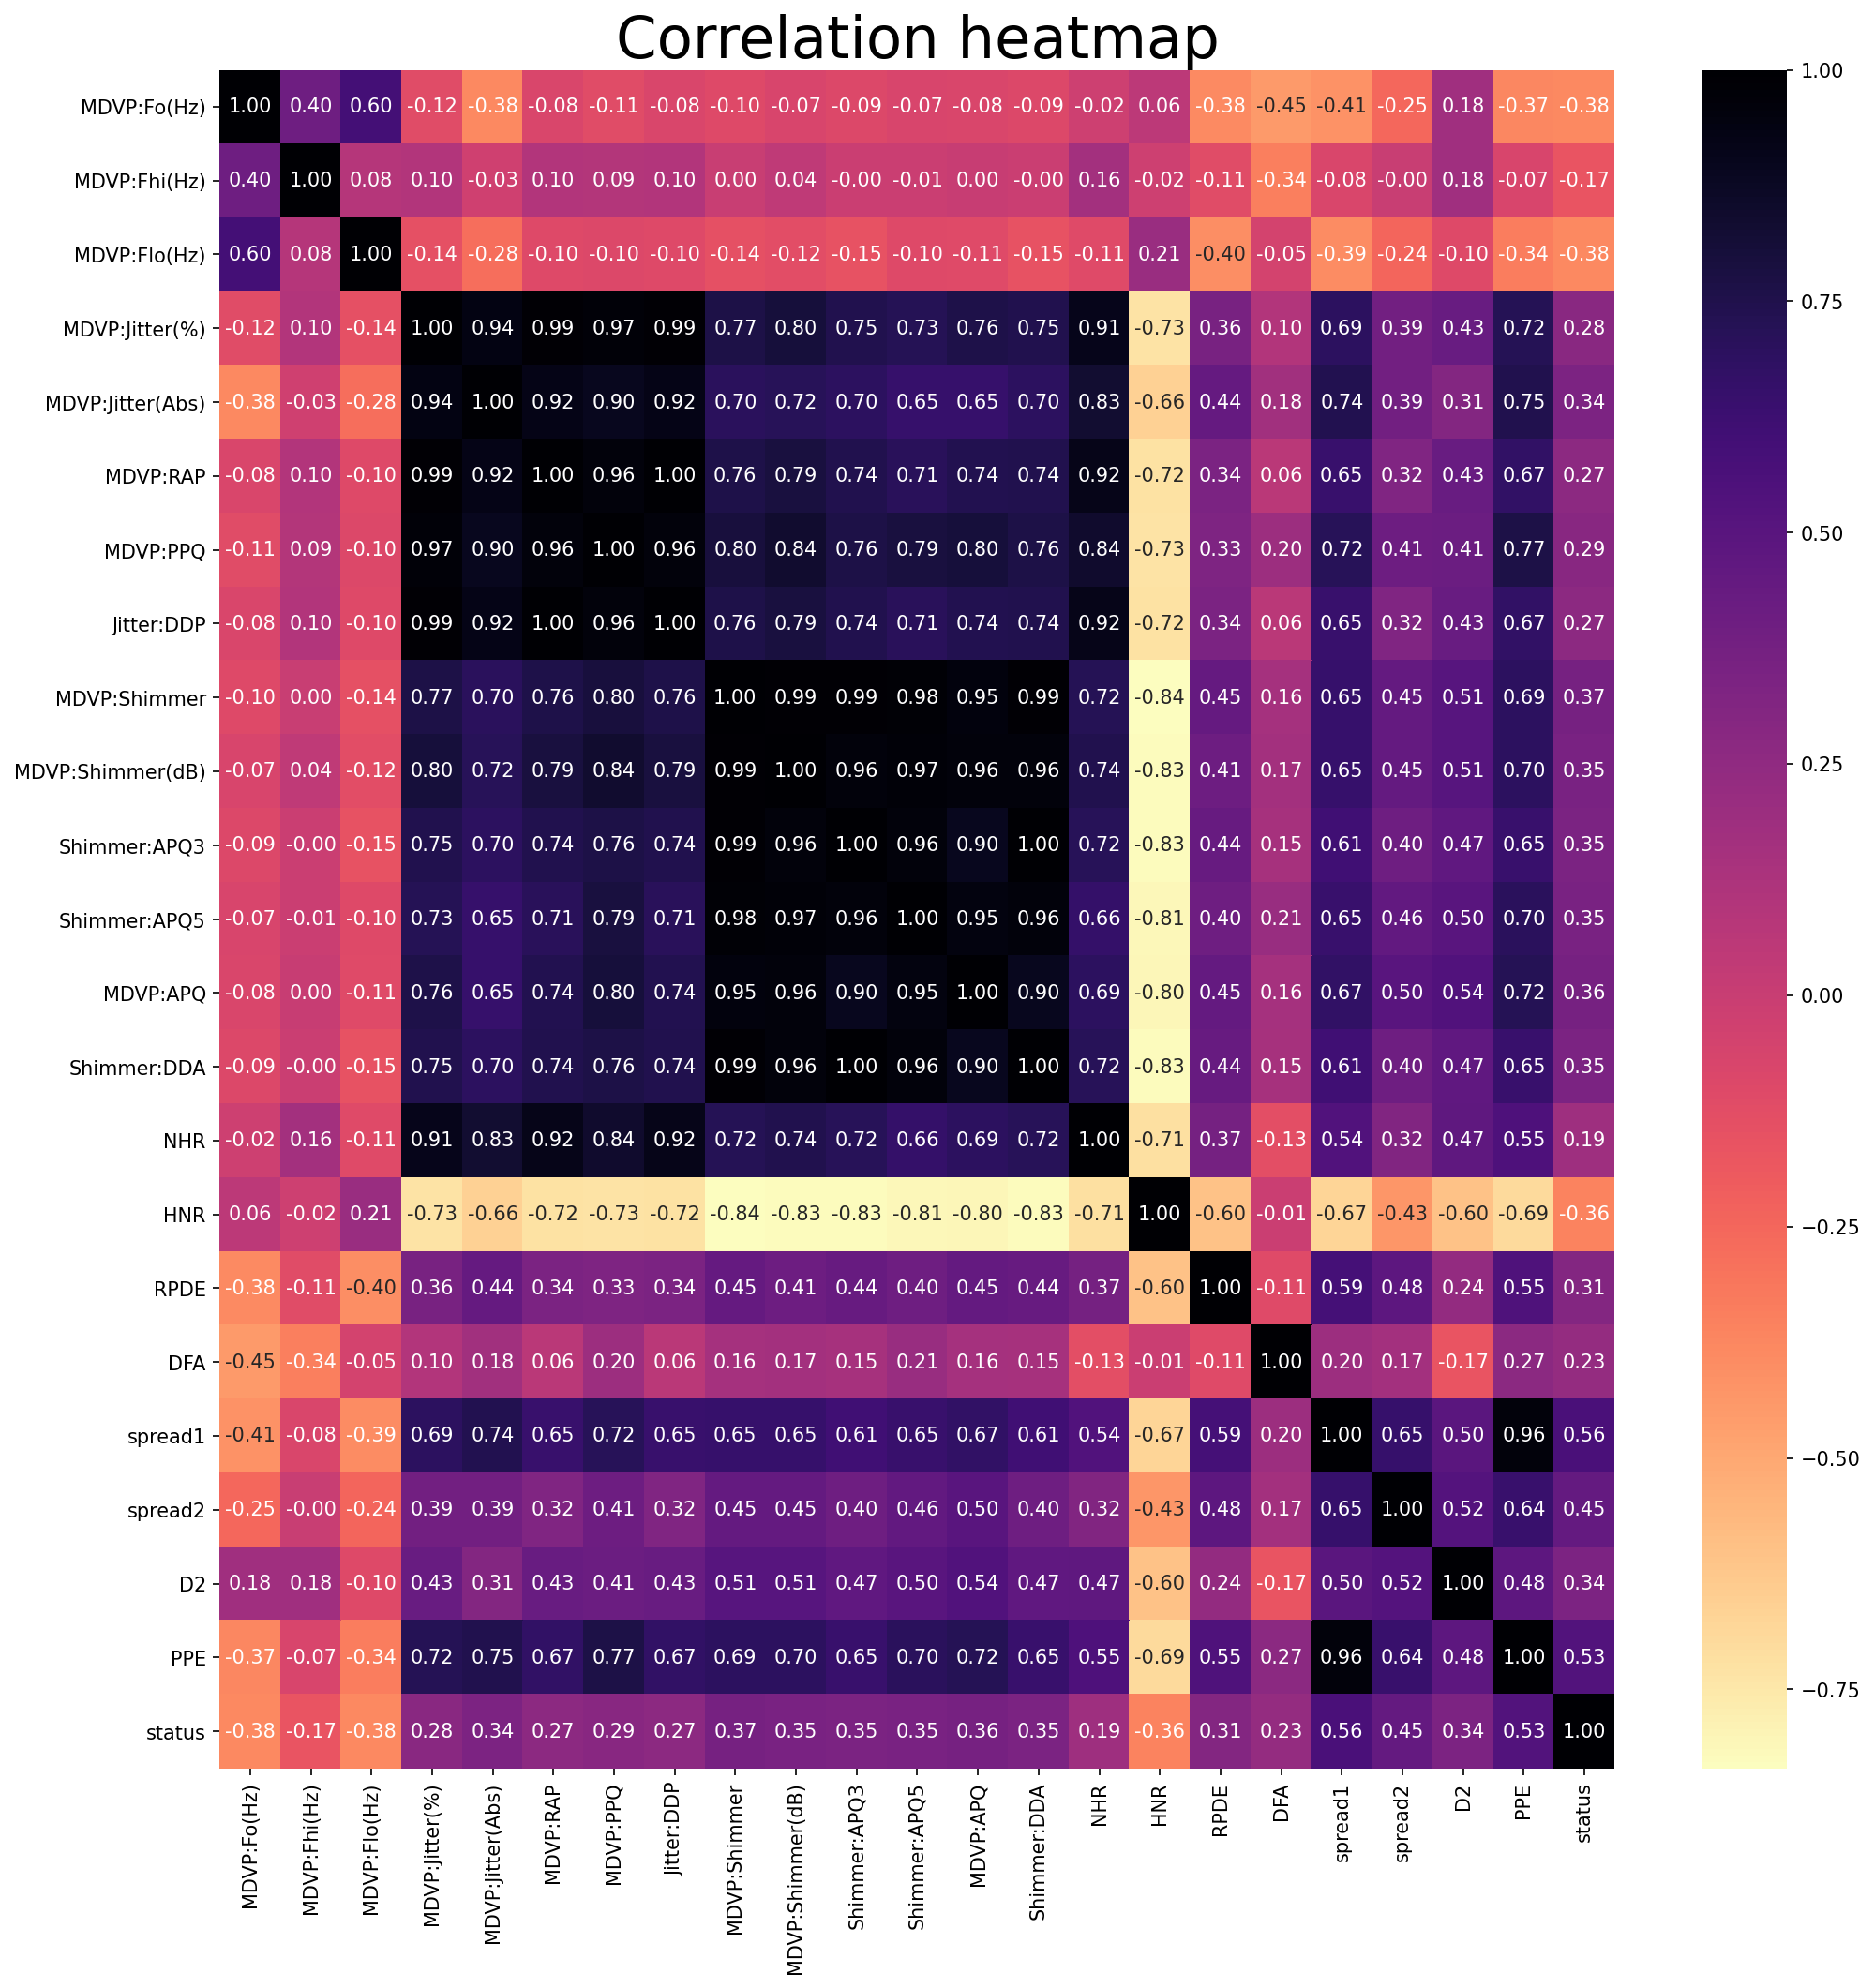

In [7]:
plt.figure(dpi=150, figsize=(16,16))
sns.heatmap(data[data.columns[0:24]].corr(), annot=True, fmt=".2f", cmap="magma_r")
plt.title("Correlation heatmap", fontsize=30)

The main thing that should be intriguing us, is correlation between features and status-label.

The strongest correlation with status is detected for "spread1" and "PPE", but still they are not on super-high level
We can't deny status dependance on other features.

1.4.2. Class count

Text(0.5, 1.0, 'Class count')

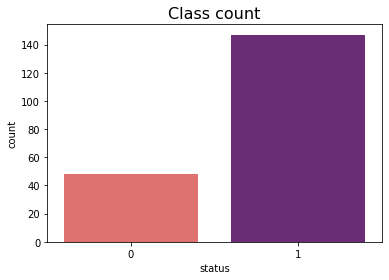

In [8]:
plt.figure()
sns.countplot(data["status"], palette="magma_r")
plt.title("Class count", fontsize=16)

1.4.3. Skewness of features

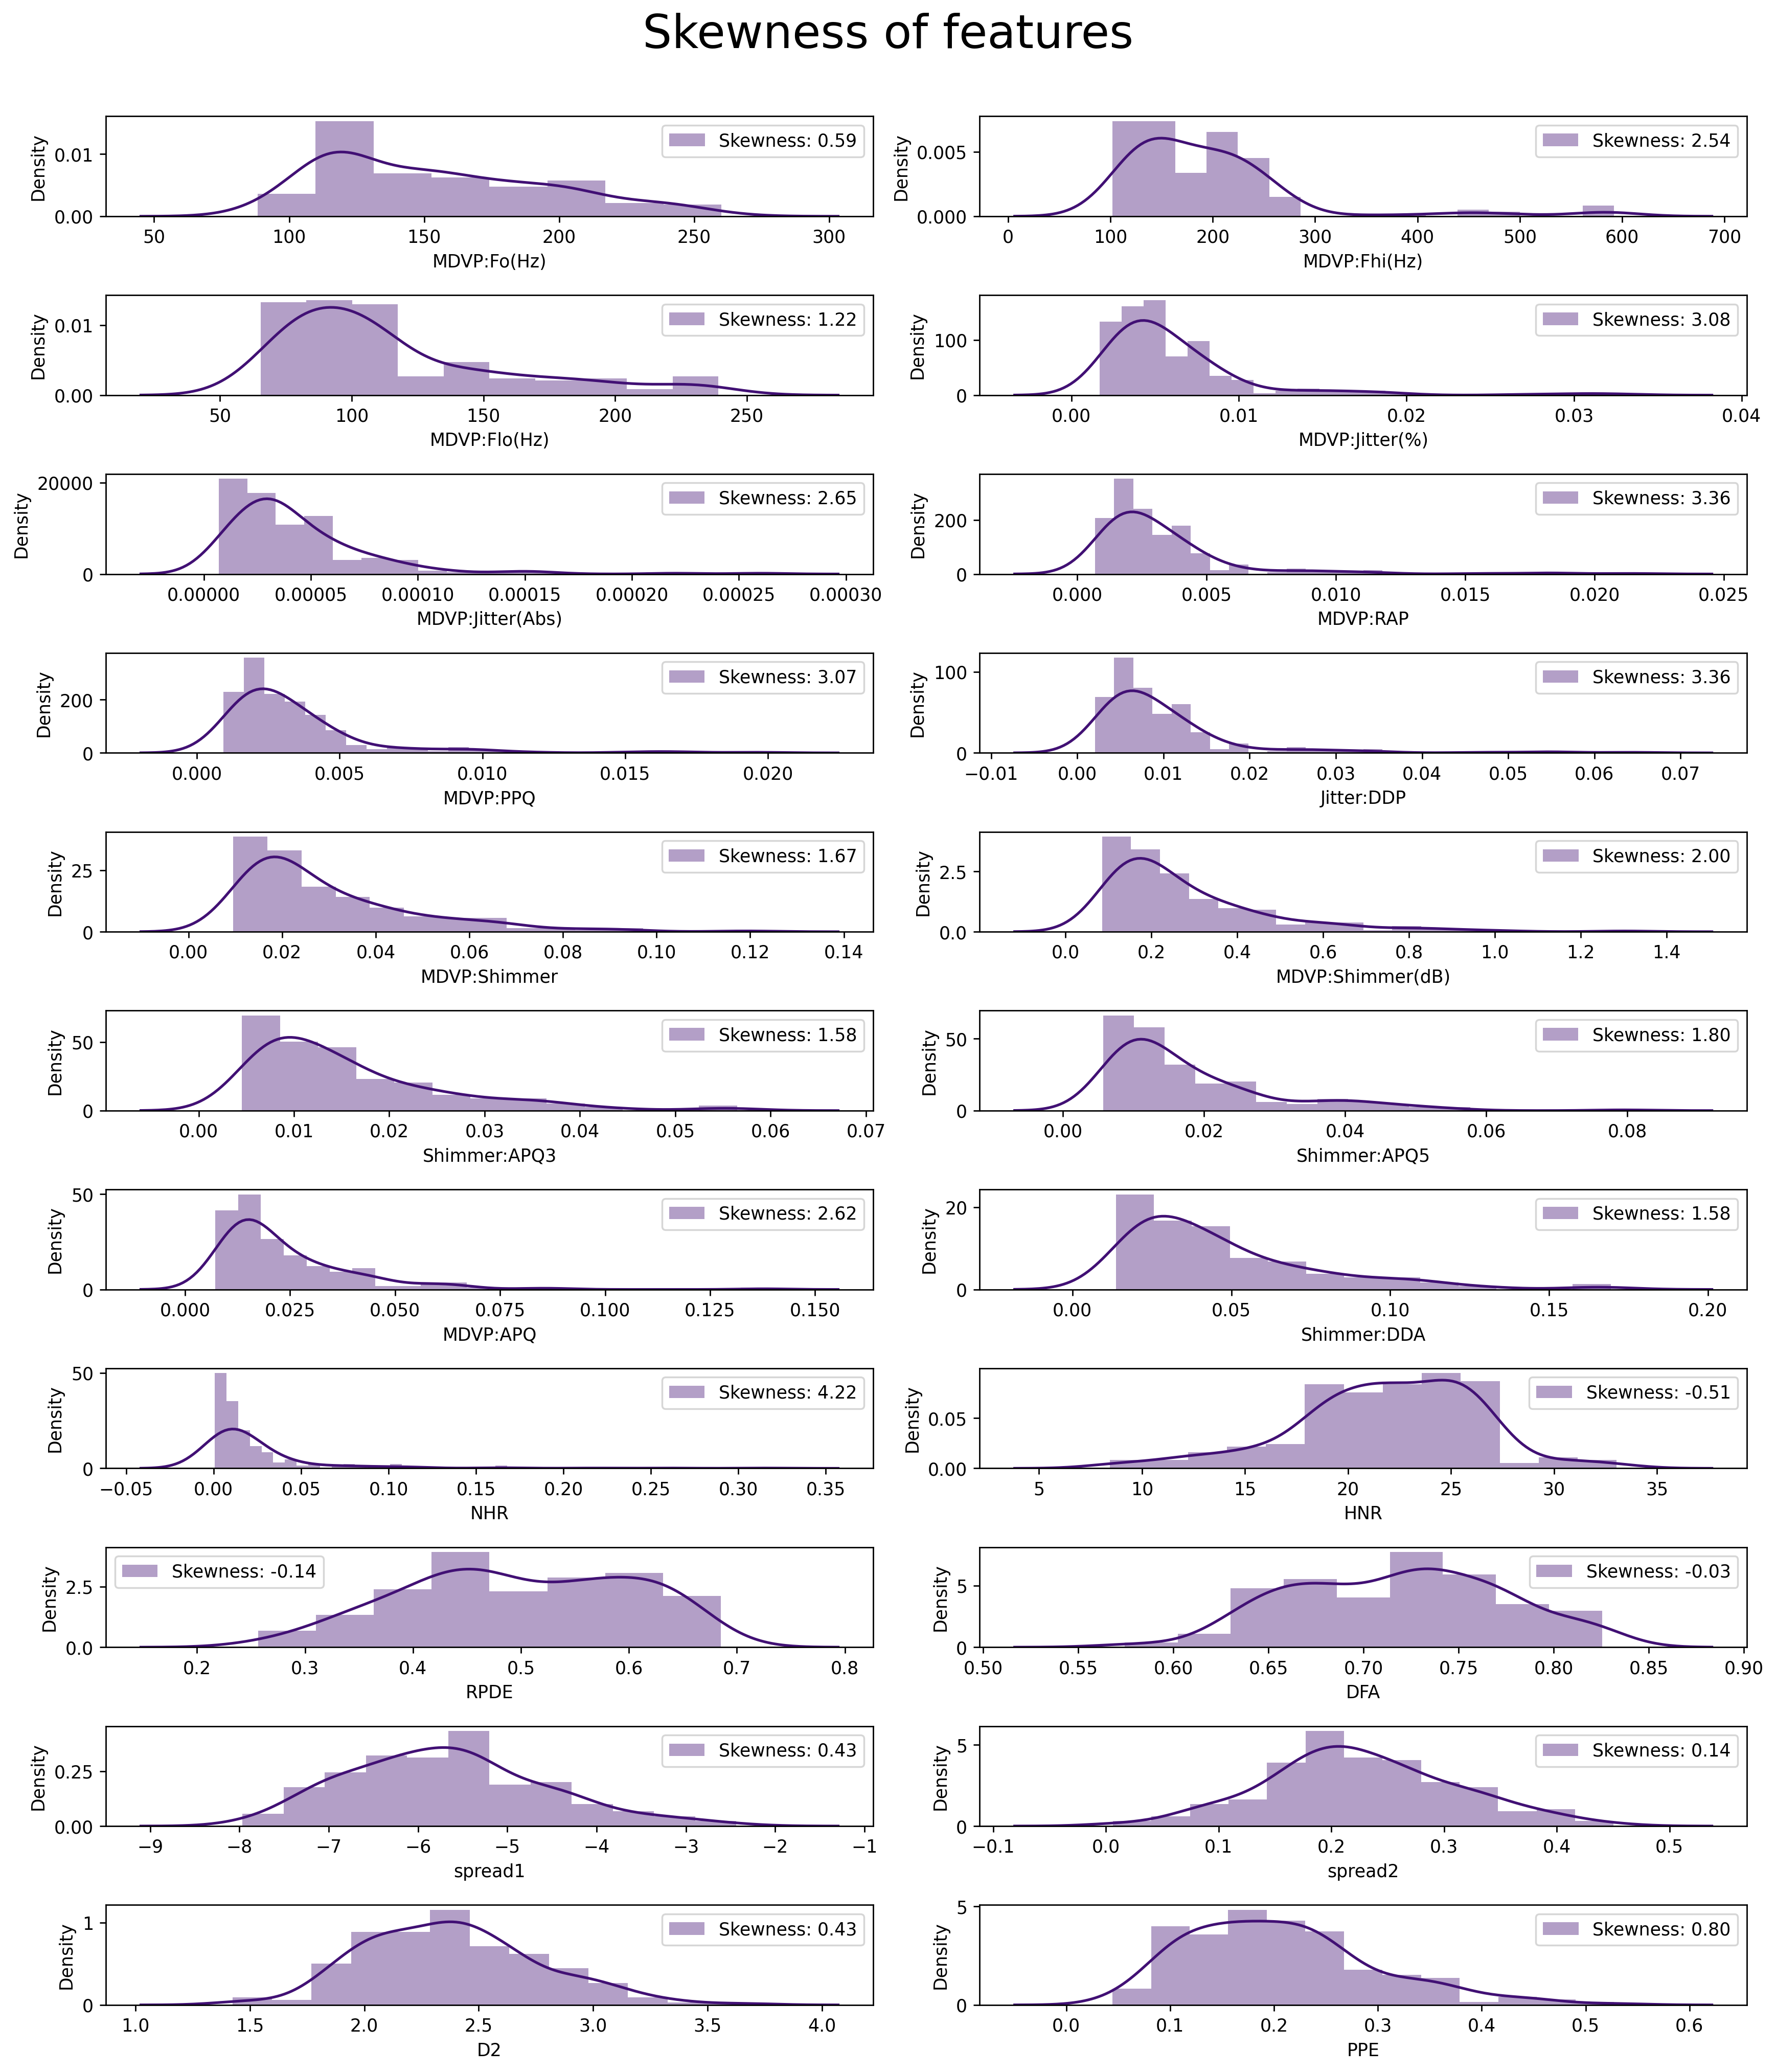

In [9]:
skewness = [data[feature].skew() for feature in data.columns[1:23]]

plt.figure(figsize=(14,16), dpi=250)
for i, skew, feature in zip(range(1,23), skewness, data.columns[1:23]):
    plt.subplot(11,2,i)
    sns.distplot(data[feature], color="#411074", label="Skewness: %.2f"%(skew))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.suptitle("Skewness of features", fontsize=26, y=1.01)

### 1.5. Log transformation

Performing log transform on the mostly skewed features along the dataset
For the statistical model the tail region may act as an outlier, so instead of dropping samples having outliers as mentioned before, I decided to perform log transform on those with the highest skewness

In [10]:
skewed_feature = data.columns[[skewness.index(i)+1 for i in skewness if i > 3.3]] # +1 as there is still 'name' feature
skewed_feature

Index(['MDVP:RAP', 'Jitter:DDP', 'NHR'], dtype='object')

Text(0.51, 1.15, 'Log transform')

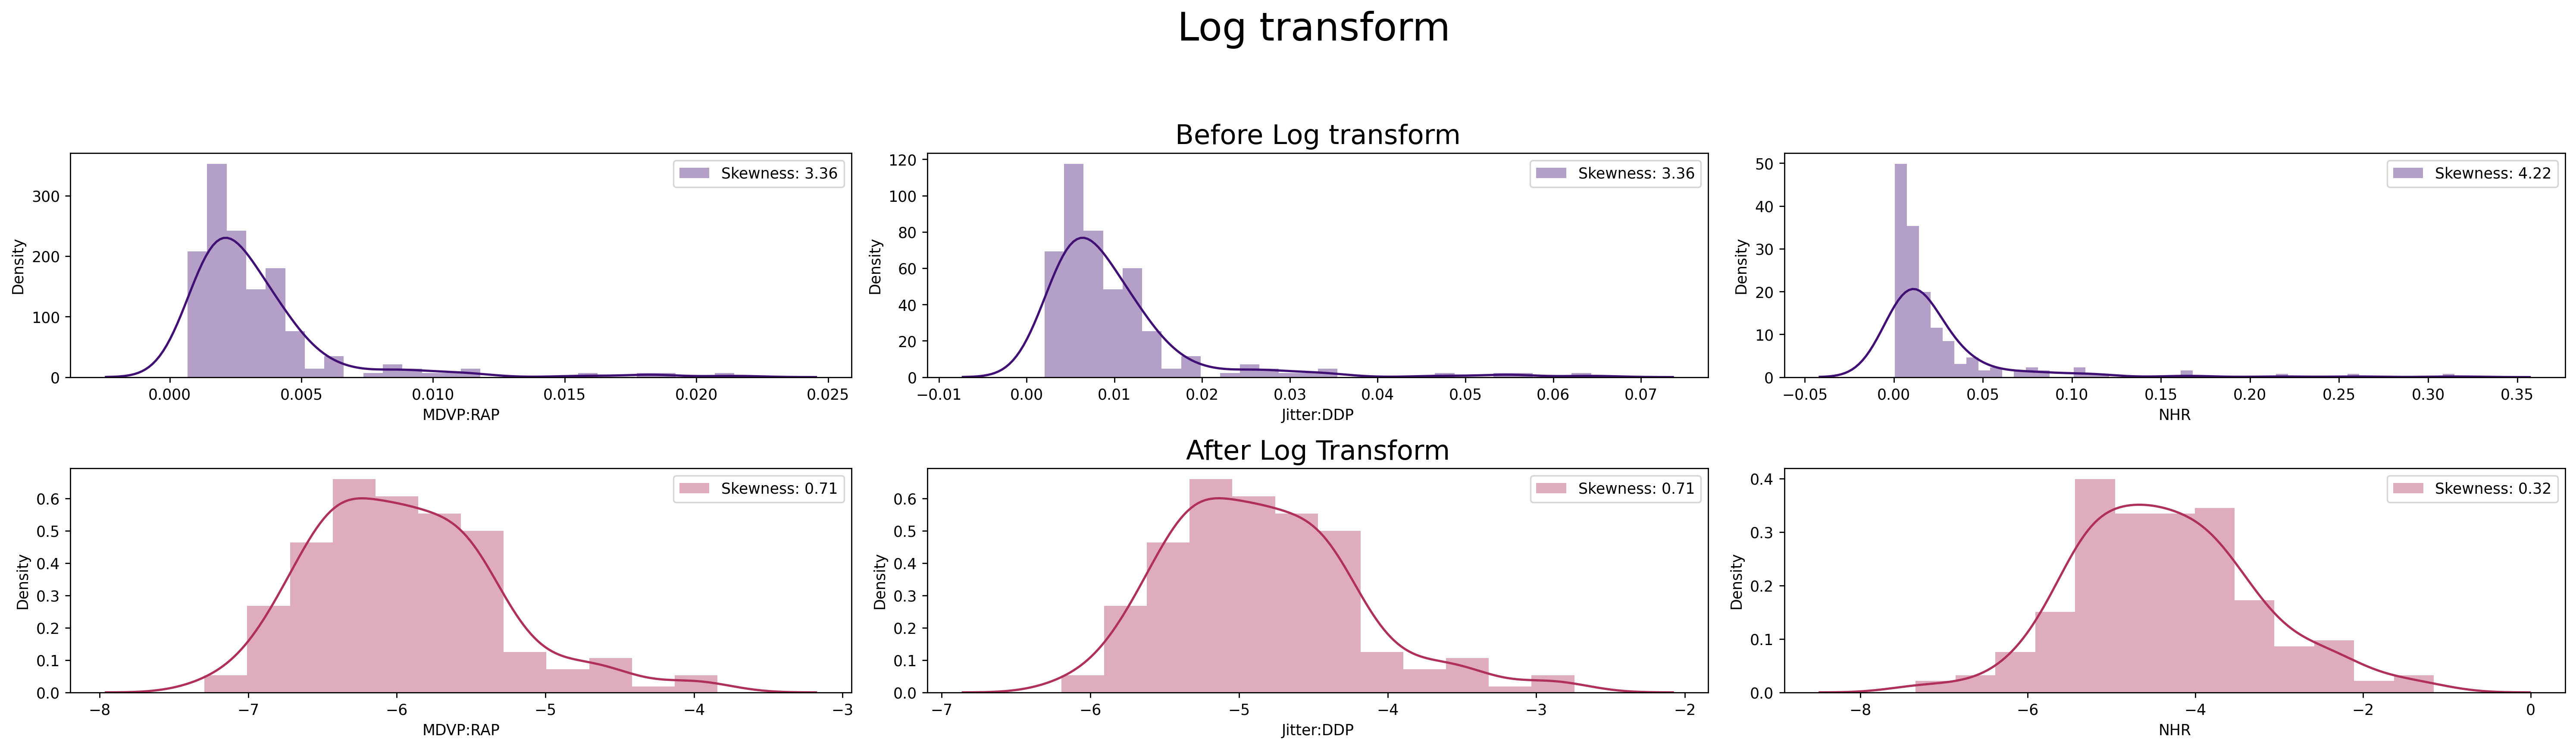

In [11]:
plt.figure(dpi=250, figsize=(24, 6))
plt.subplot(2,3,1)
sns.distplot(data["MDVP:RAP"], color="#411074", label="Skewness: %.2f"%(skewness[5]))
plt.legend(loc="best")
plt.tight_layout()

plt.subplot(2,3,2)
sns.distplot(data["Jitter:DDP"], color="#411074", label="Skewness: %.2f"%(skewness[7]))
plt.legend(loc="best")
plt.tight_layout()
plt.title("Before Log transform", fontsize=18)

plt.subplot(2,3,3)
sns.distplot(data["NHR"], color="#411074", label="Skewness: %.2f"%(skewness[14]))
plt.legend(loc="best")
plt.tight_layout()


data["MDVP:RAP"] = data["MDVP:RAP"].map(lambda x: np.log(x))
data["Jitter:DDP"] = data["Jitter:DDP"].map(lambda x: np.log(x))
data["NHR"] = data["NHR"].map(lambda x: np.log(x))


plt.subplot(2,3,4)
sns.distplot(data["MDVP:RAP"], color="#af315b", label="Skewness: %.2f"%(data["MDVP:RAP"].skew()))
plt.legend(loc="best")
plt.tight_layout()

plt.subplot(2,3,5)
sns.distplot(data["Jitter:DDP"] , color="#af315b", label="Skewness: %.2f"%(data["Jitter:DDP"].skew()))
plt.legend(loc="best")
plt.tight_layout()
plt.title("After Log Transform", fontsize=18)

plt.subplot(2,3,6)
sns.distplot(data["NHR"], color="#af315b", label="Skewness: %.2f"%(data["NHR"].skew()))
plt.legend(loc="best")
plt.tight_layout()

plt.suptitle("Log transform", fontsize=26, y =1.15, x=0.51)

### 1.6. Train and test set ##

In [12]:
X = data.drop(["name", "status"], axis=1)
y = data["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True, random_state=1, stratify=y)

## 2. Modeling

### 2.1. Classifier selection

In [13]:
# Decided to go for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

tree = DecisionTreeClassifier(criterion="gini", random_state=1)

### 2.2. Hyperparameters tuning

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

2.2.1. Nested Cross-validation

Decided to perform both tuning and validating with a 10x3 Nested Cross-validation technique

In [15]:
kfold_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # learning
kfold_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) # hyperparams tuning

In [16]:
params = {"max_depth": list(range(3,10)), "max_features": list(range(1,23))}

In [46]:
searching = RandomizedSearchCV(tree, params, cv=kfold_inner, scoring="accuracy", n_iter=20, verbose=1)
scores = cross_val_score(searching, X_train, y_train, cv=kfold_outer, scoring="accuracy")
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Accuracy: 0.861 +/- 0.052


In [47]:
searching.fit(X_train,y_train)
searching.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'max_features': 1, 'max_depth': 6}

In [48]:
searching.best_score_

0.8484848484848485

Parameters such as min_samples_leaf or max_leaf_nodes were not tuned on the purpose, so the tree might have been overfitted. It will be later on reduced, using a post-training pruning technique, like cost-complexity pruning.

In [49]:
tree_classifier = searching.best_estimator_
tree_classifier

DecisionTreeClassifier(max_depth=6, max_features=1, random_state=1)

### 2.3. Learning curves

In [50]:
from sklearn.model_selection import learning_curve

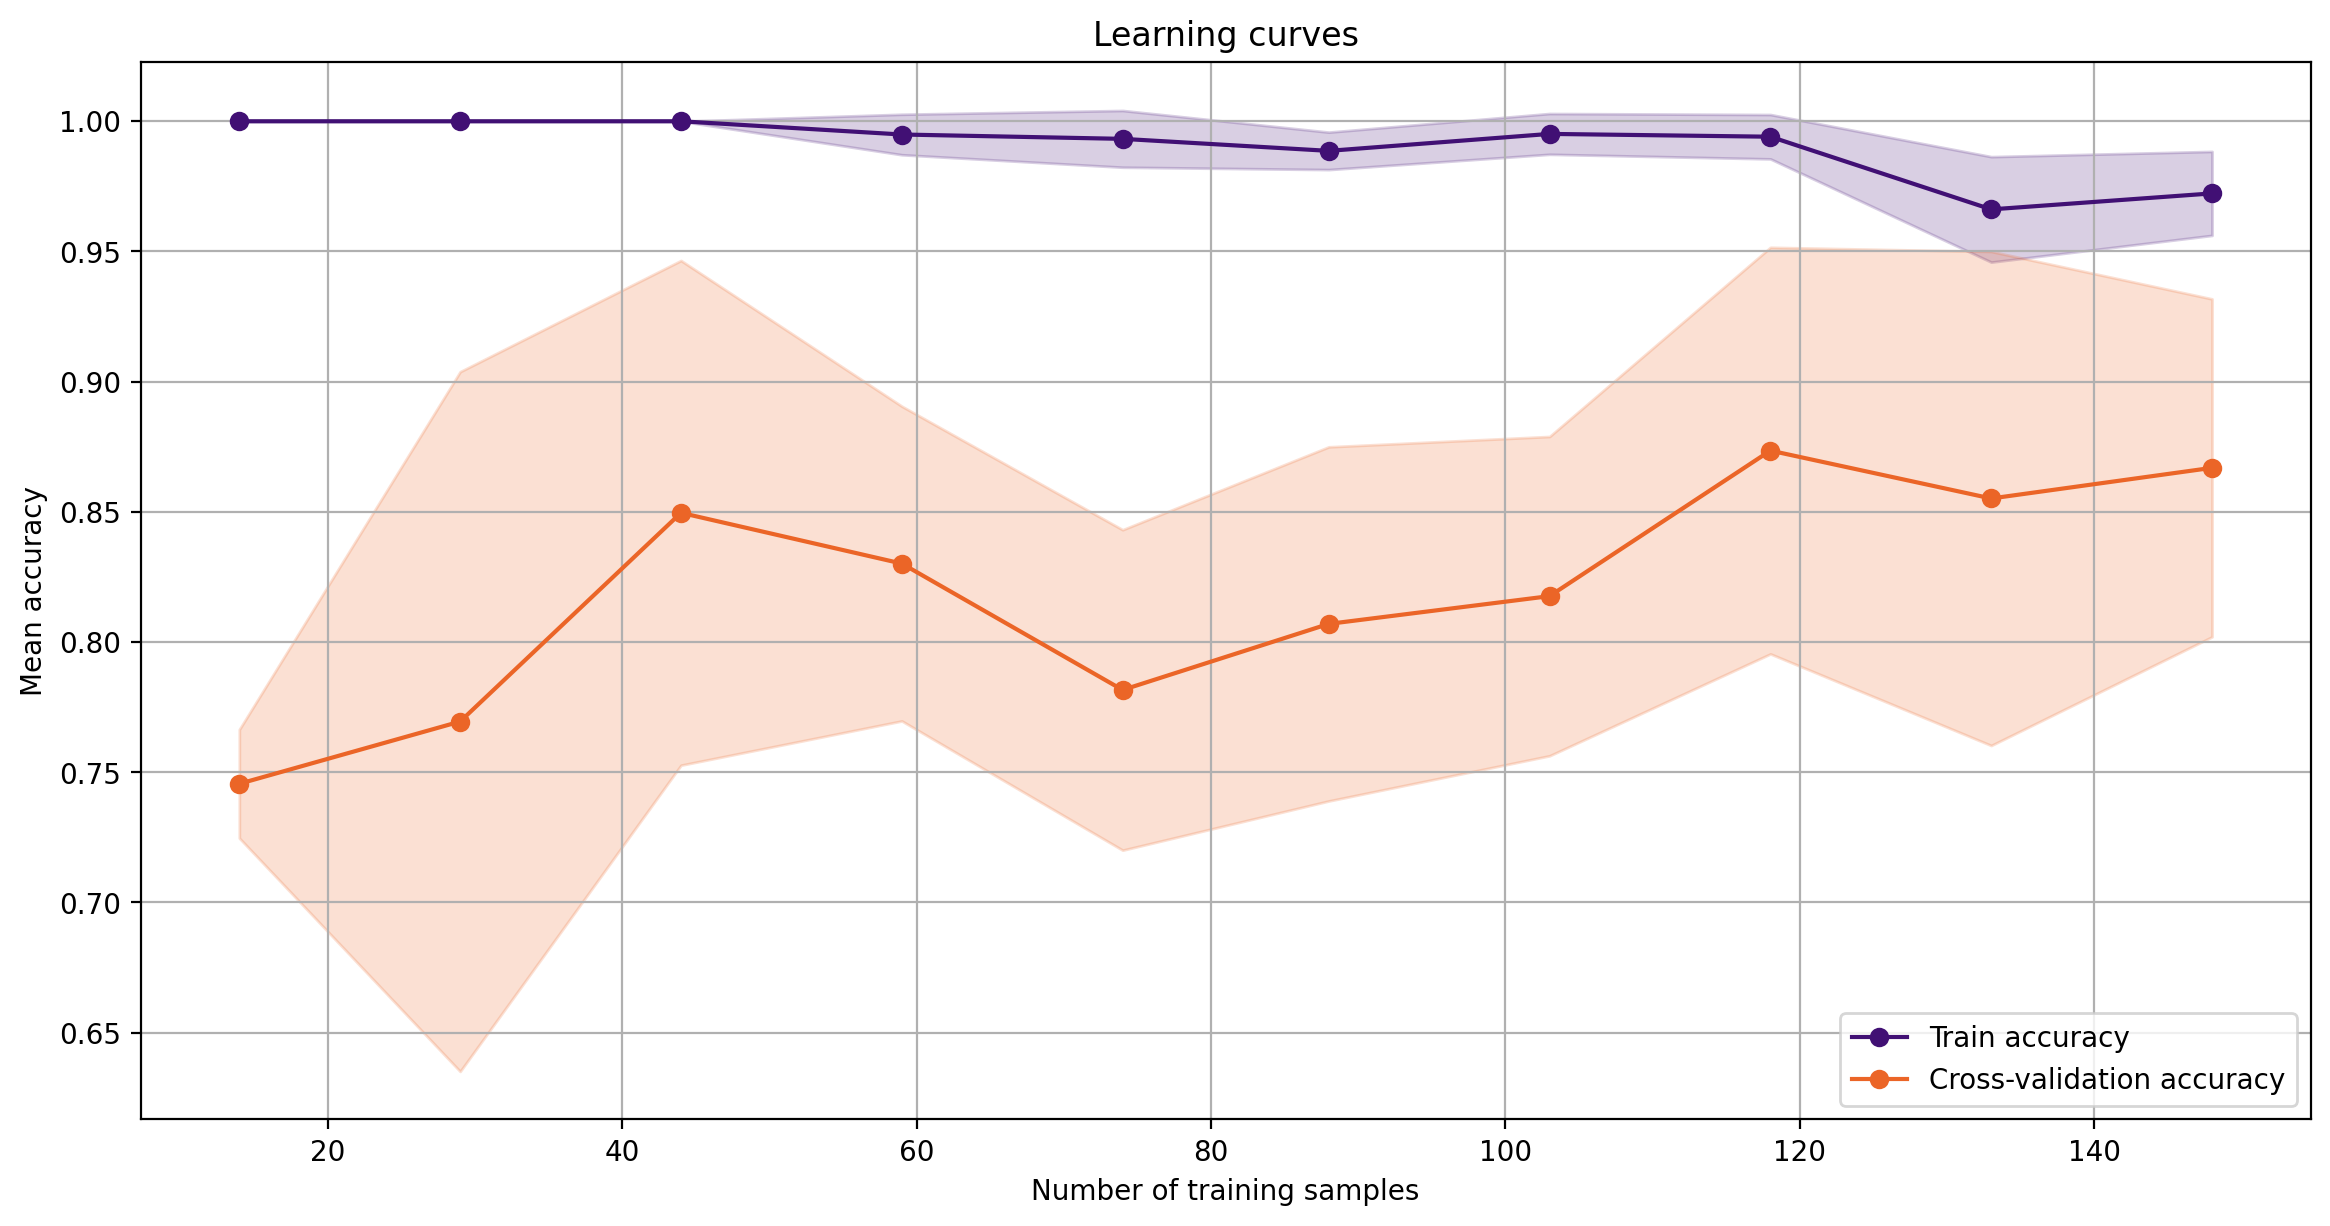

In [51]:
train_sizes, train_scores, val_scores = learning_curve(estimator=tree_classifier, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=kfold_outer)

# kfold_outer iterations (10) for each train_size (10) -> shapes of scores: [10,10]

train_mean = np.mean(train_scores, axis=1) # in rows
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(dpi=200, figsize=(14,7))
plt.plot(train_sizes, train_mean, color="#411074", marker="o", label="Train accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.2, color="#411074")

plt.plot(train_sizes, val_mean, color="#eb6527", marker="o", label="Cross-validation accuracy")
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.2, color="#eb6527")

plt.grid(True)
plt.xlabel("Number of training samples")
plt.ylabel("Mean accuracy")
plt.title("Learning curves")
plt.legend(loc="lower right")

While having over +/- 130 training samples the gap between training and validation accuracy tends to increase, which corresponds to a progressive overfitting.

### 2.4. Validation curves

Model's performance will be analysed for both hyperparameters (max_depth and max_features) tuned in stage 2.2.

In [52]:
from sklearn.model_selection import validation_curve

In [53]:
def get_val_curve(param_name, param_range, param_label):
    train_scores_vc, val_scores_vc = validation_curve(estimator=tree_classifier, X=X_train, y=y_train, param_name=param_name, param_range=param_range)

    train_mean_vc = np.mean(train_scores_vc, axis=1)
    val_mean_vc = np.mean(val_scores_vc, axis=1)
    train_std_vc = np.std(train_scores_vc, axis=1)
    val_std_vc = np.std(val_scores_vc, axis=1)

    fig = plt.plot(param_range, train_mean_vc, color="#411074", marker="o", label="Train accuracy")
    fig = plt.fill_between(param_range, train_mean_vc + train_std_vc, train_mean_vc - train_std_vc, alpha=0.2, color="#411074")

    fig = plt.plot(param_range, val_mean_vc, color="#eb6527", marker="o", label="Cross-validation accuracy")
    fig = plt.fill_between(param_range, val_mean_vc + val_std_vc, val_mean_vc - val_std_vc, alpha=0.2, color="#eb6527")

    fig = plt.grid(True)
    fig = plt.xlabel(param_label)
    fig = plt.ylabel("Mean accuracy")
    fig = plt.title(param_label + " validation curves")
    fig = plt.legend(loc="lower right")

    return fig

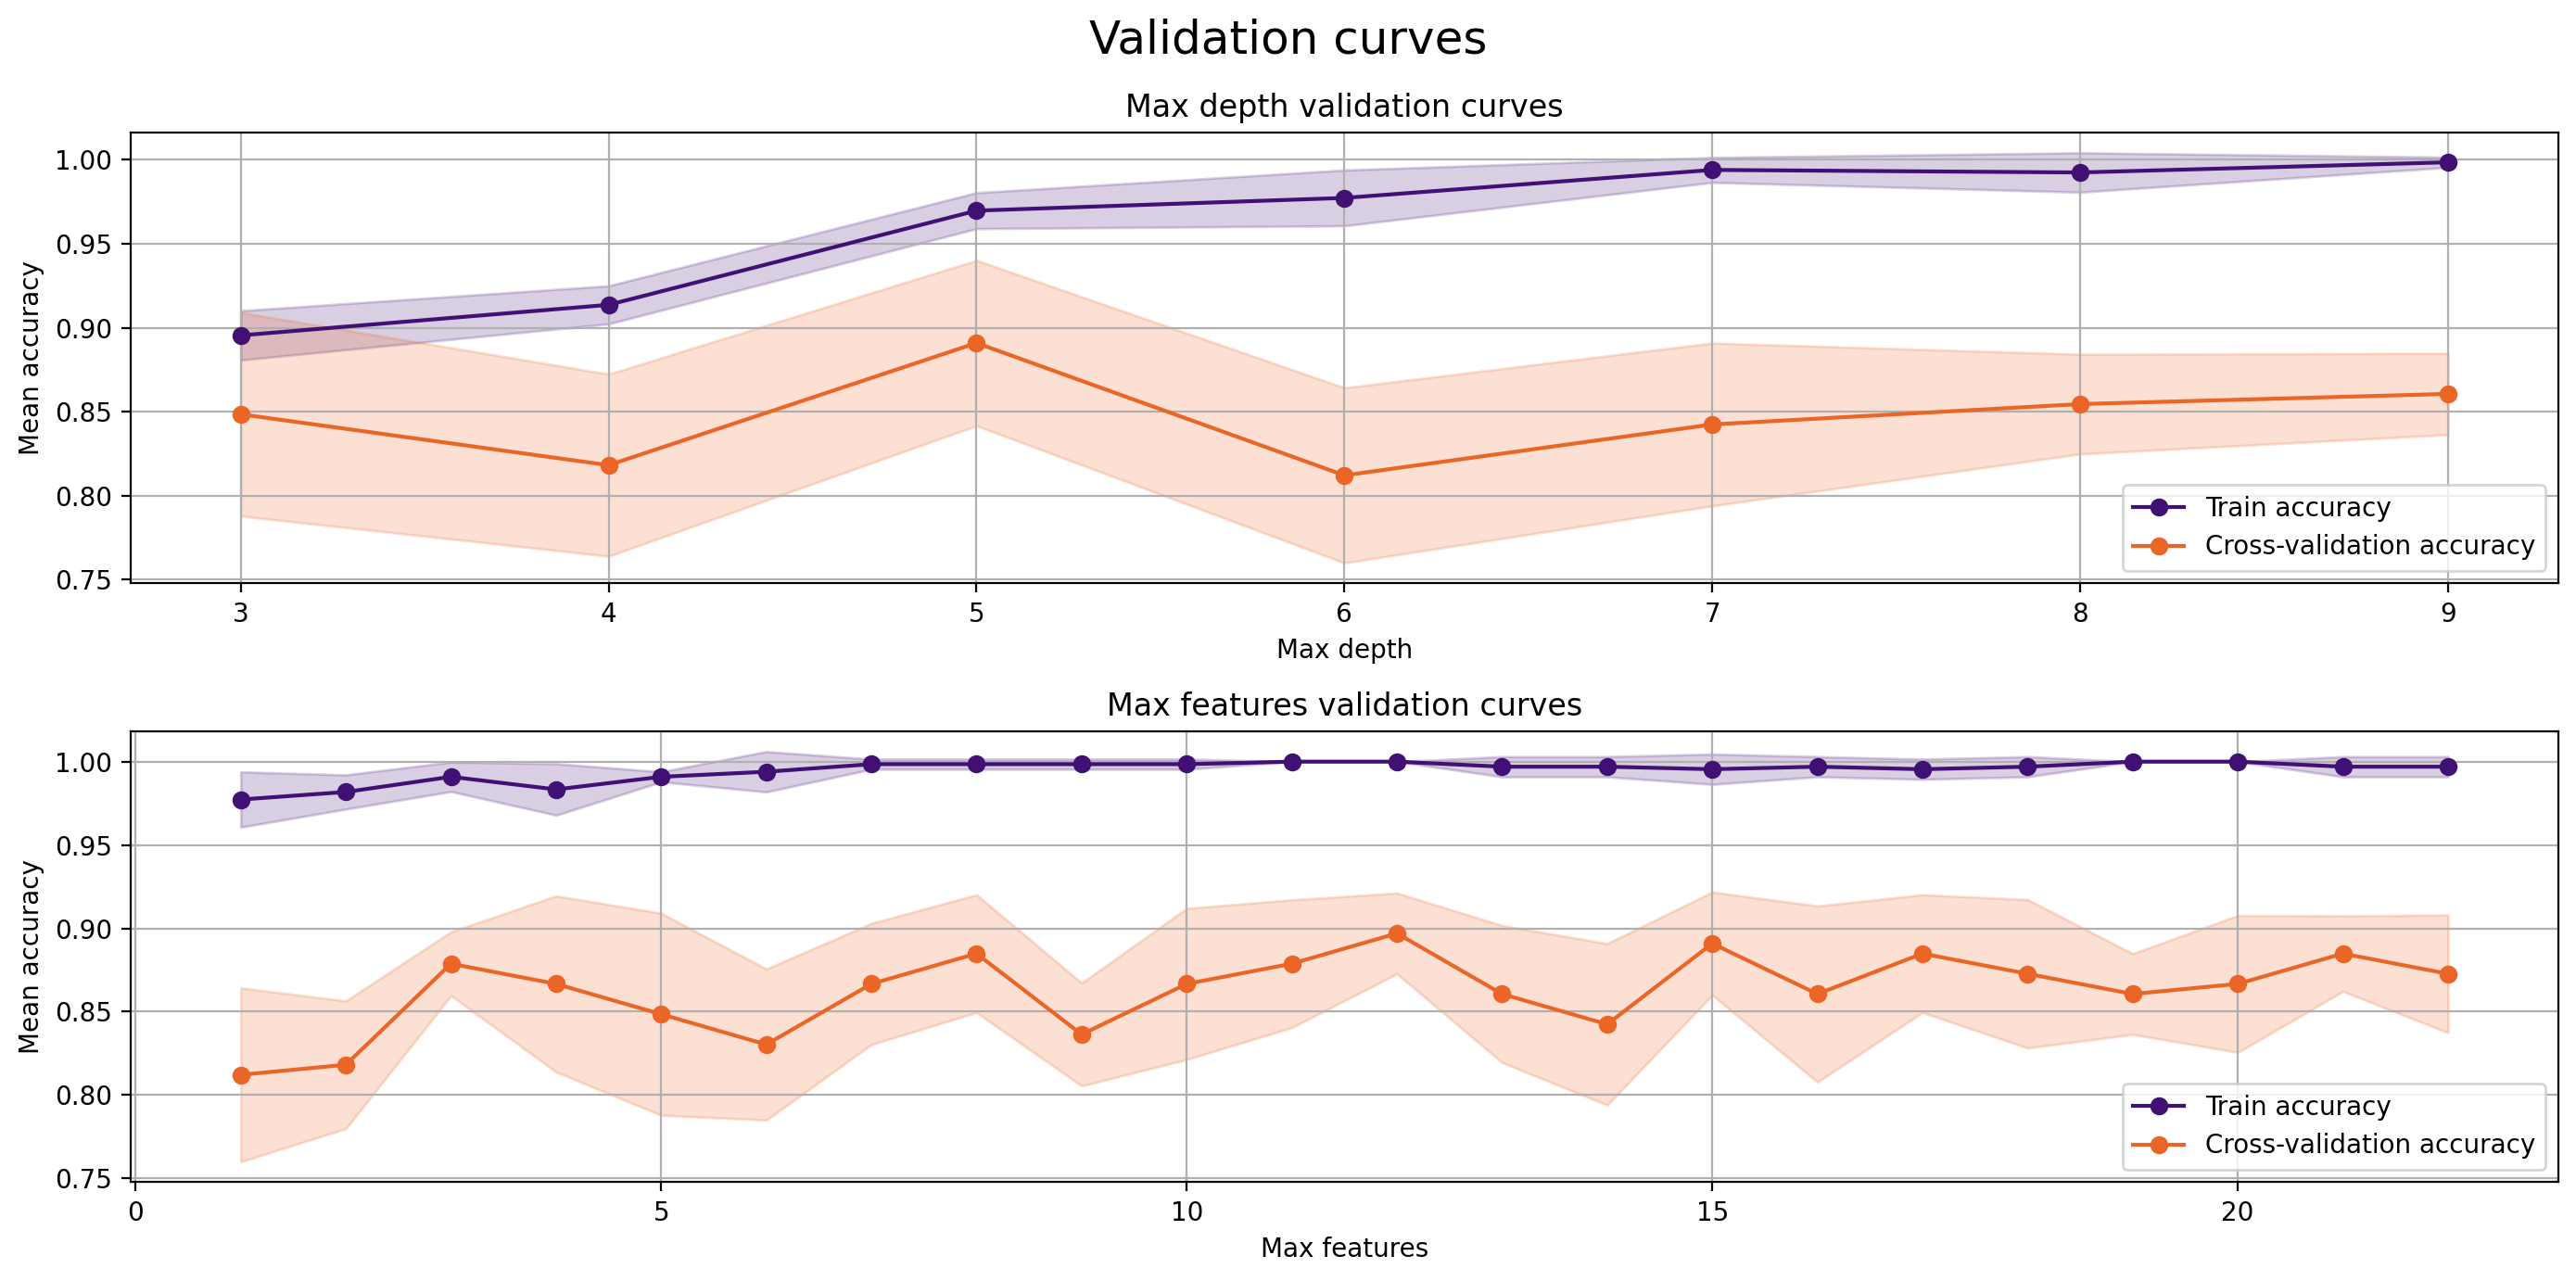

In [54]:
plt.figure(dpi=200, figsize=(14,7))
for i, param_name, param_range, param_label in zip([1,2], ["max_depth", "max_features"], [list(range(3,10)), list(range(1,23))], ["Max depth", "Max features"]):
    plt.subplot(2,1,i)
    get_val_curve(param_name, param_range, param_label)
    plt.tight_layout()
    plt.suptitle("Validation curves", fontsize=18)

In fact, the best hyperparameters combination gained during RandomSearch seems to be different to the ones we can conclude from the plots. The reason for that is that the procedure of plotting validation curves was performed only on a single hyperparameter and it's only purpose here was to visualize how it affects the accuracy score.

### 2.5. ROC curve and AUC

In [55]:
from sklearn.metrics import roc_curve, auc

In [56]:
tree_classifier.fit(X_train, y_train)
probas = tree_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'ROC curve')

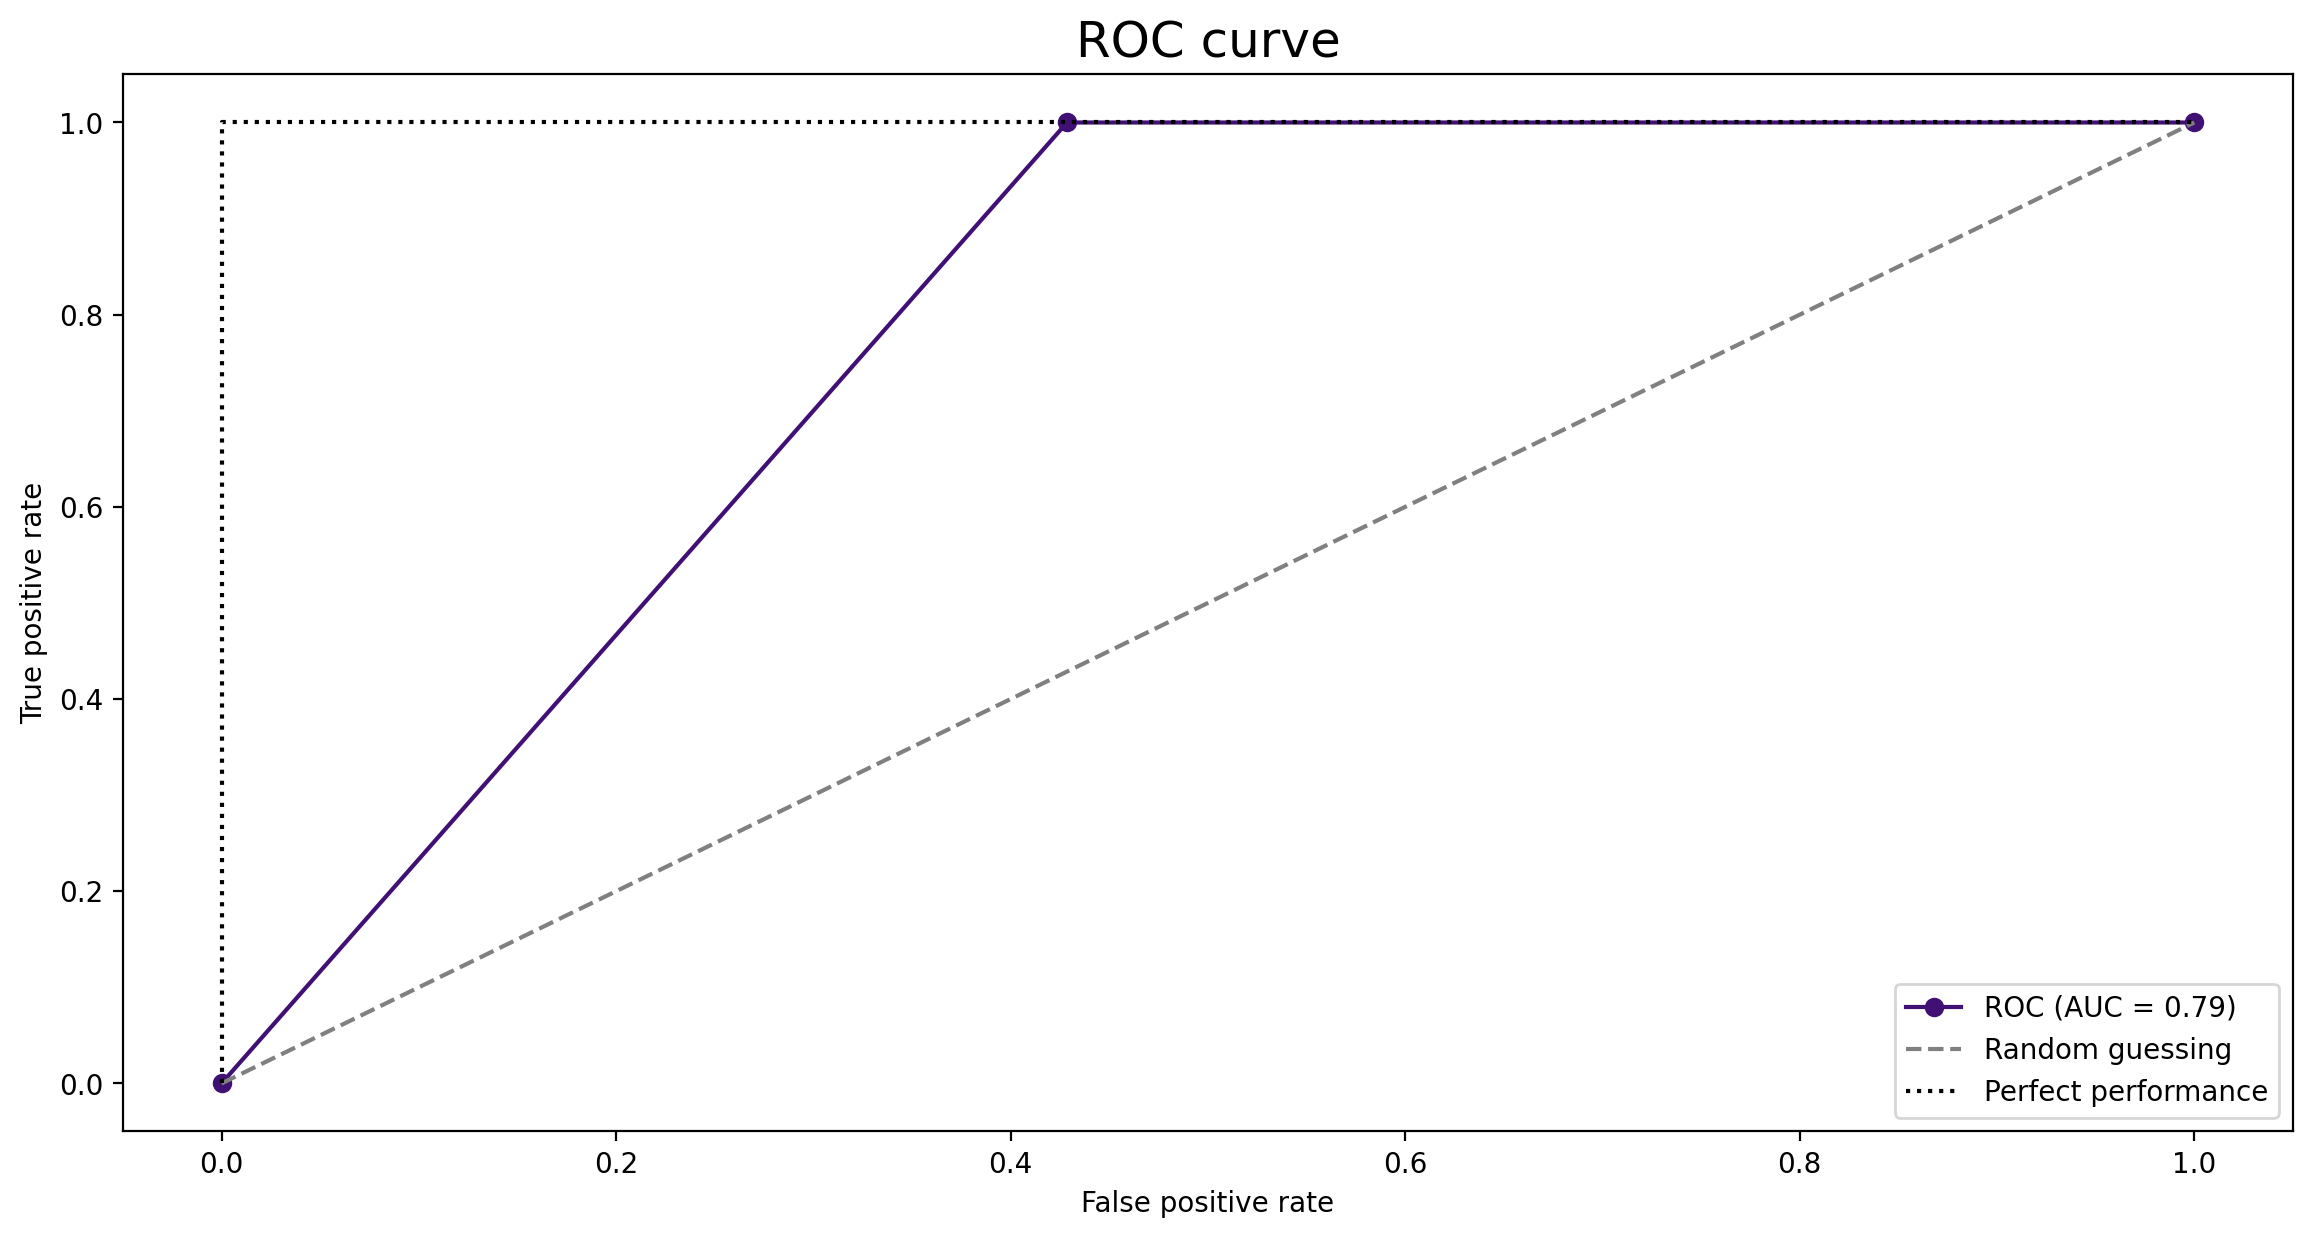

In [57]:
plt.figure(dpi=200, figsize=(14,7))
plt.plot(fpr, tpr, color="#411074", marker="o", label="ROC (AUC = %.2f)" % (roc_auc))
plt.plot([0, 1], [0,1], linestyle="--", color="gray", label="Random guessing")
plt.plot([0,0,1], [0,1,1], linestyle=":", color="black", label="Perfect performance")
plt.legend(loc="best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve", fontsize=18)

### 2.6. Prediction

In [58]:
y_pred = tree_classifier.predict(X_test)
acc_score = tree_classifier.score(X_test, y_test)

In [59]:
acc_score

0.9

Model seems to have a pretty good accuracy on the new (test) dataset

## 3. Post-processing and final analysis

### 3.1. Confusion matrix

In [60]:
from sklearn.metrics import plot_confusion_matrix

Text(0.5, 1.0, 'Confusion matrix')

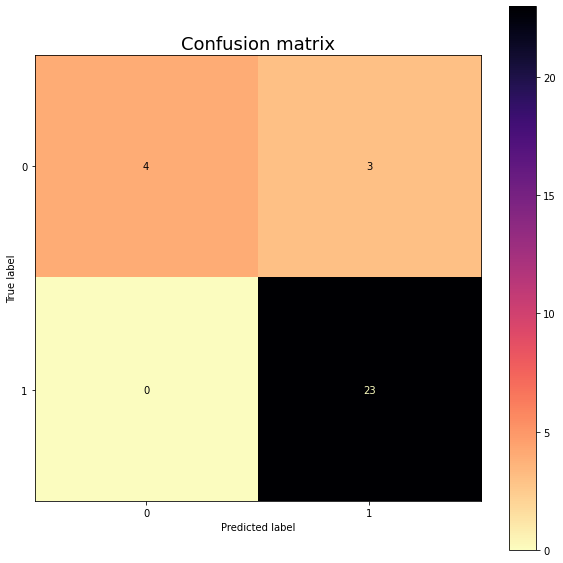

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(tree_classifier, X_test, y_test, cmap="magma_r", display_labels=["0", "1"], ax=ax)
plt.title("Confusion matrix", fontsize=18)

### 3.2. Cost complexity pruning

To avoid model overfitting, post-training pruning technique will be performed. Nodes with least value of effective alpha coefficent should be pruned

In [68]:
path = tree_classifier.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print("Effective alpha coefficents: \n", ccp_alphas)
print("\nImpurities: \n", impurities)

Effective alpha coefficents: 
 [0.         0.00394644 0.00454545 0.00454545 0.00616086 0.0085879
 0.02207792 0.0314409  0.04090909 0.05347361 0.0682171 ]

Impurities: 
 [0.05125541 0.07493406 0.08402497 0.09311588 0.09927673 0.11645254
 0.13853046 0.16997136 0.25178954 0.30526316 0.37348026]


Text(0.5, 1.0, 'Impurity in function of effective alpha')

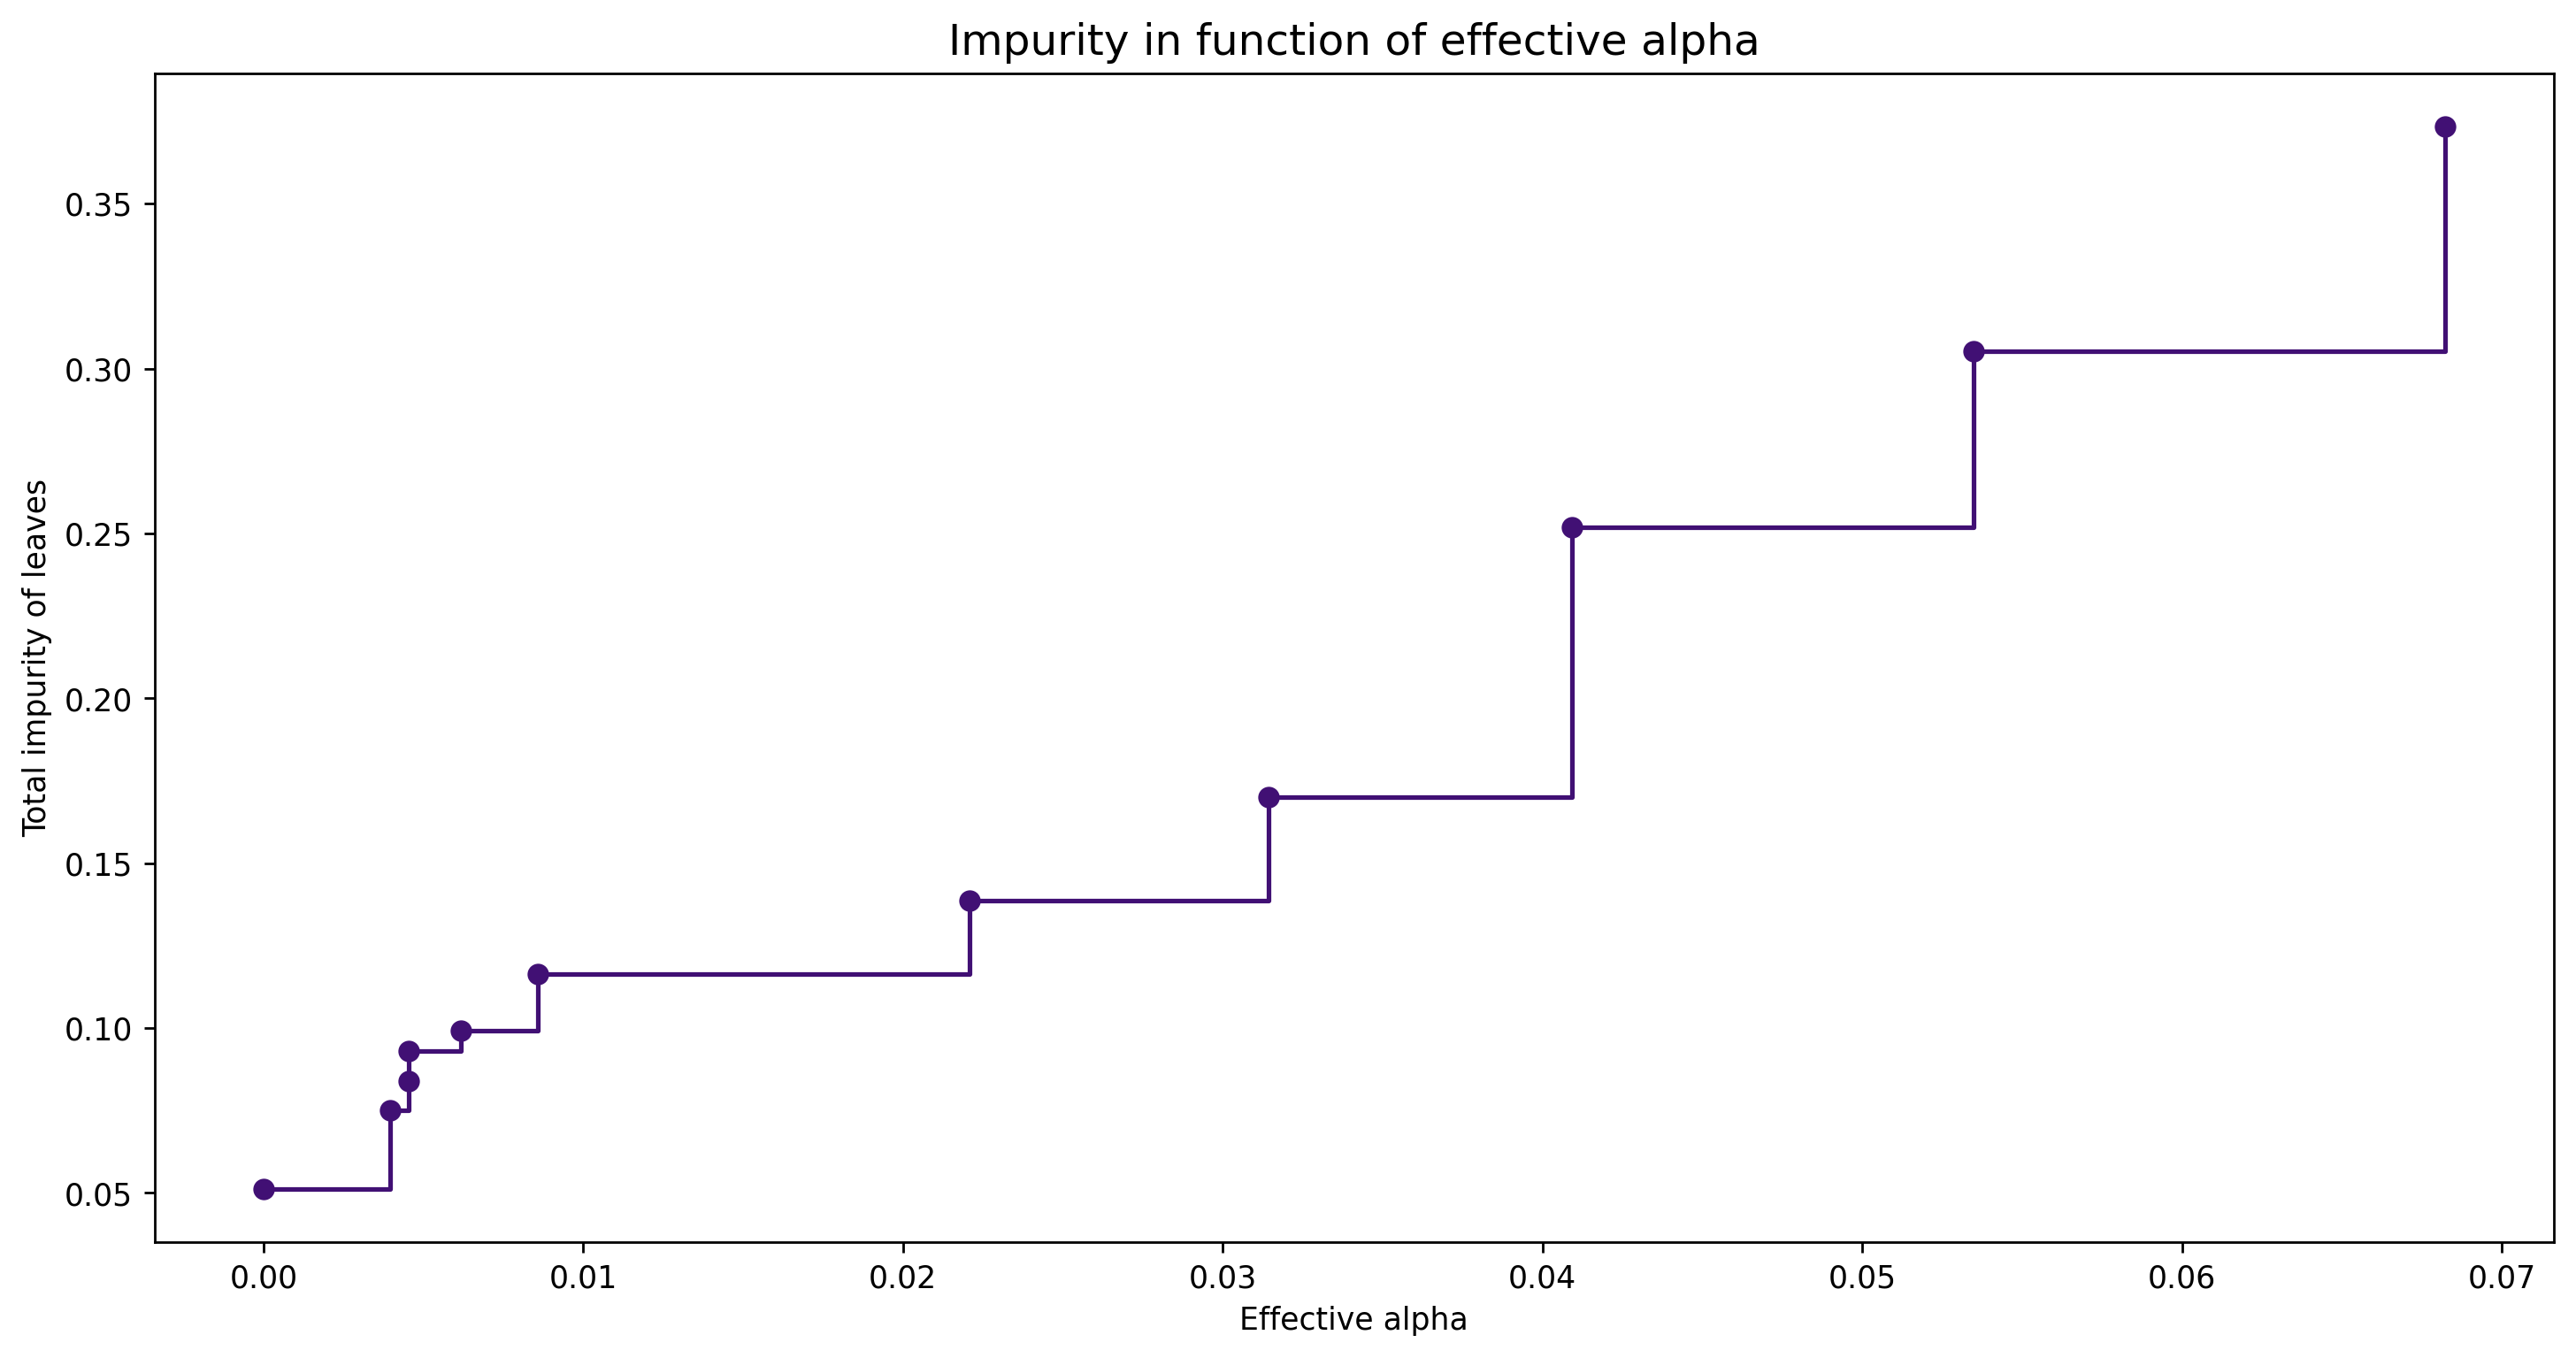

In [71]:
plt.figure(dpi=250, figsize=(14,7))
plt.step(ccp_alphas, impurities, color="#411074", marker="o", where="post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Impurity in function of effective alpha", fontsize=14)

In [81]:
classifiers = []
for ccp_alpha in ccp_alphas:
    tree_ccp = DecisionTreeClassifier(max_depth=6, max_features=1, random_state=1, ccp_alpha=ccp_alpha) 
    # params should be changed according to the ones obtained in RandomSearch due to randomness seed
    tree_ccp.fit(X_train, y_train)
    classifiers.append(tree_ccp)

# Tree with the highest ccp_alpha is just a root node
print("Number of nodes in the last tree: ", classifiers[-1].tree_.node_count)
print("ccp_alpha for the last tree: ", ccp_alphas[-1])
print("Max depth of the last tree: ", classifiers[-1].tree_.max_depth)

classifiers


Number of nodes in the last tree:  1
ccp_alpha for the last tree:  0.0682170992218839
Max depth of the last tree:  0


[DecisionTreeClassifier(max_depth=6, max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.003946441155743485, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.004545454545454545, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.004545454545454545, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.006160856687172485, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.008587903324745426, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.022077922077922085, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.031440899526005914, max_depth=6,
                        max_features=1, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.040909090909

Text(0.5, 1.0, 'Accuracy vs effective alpha')

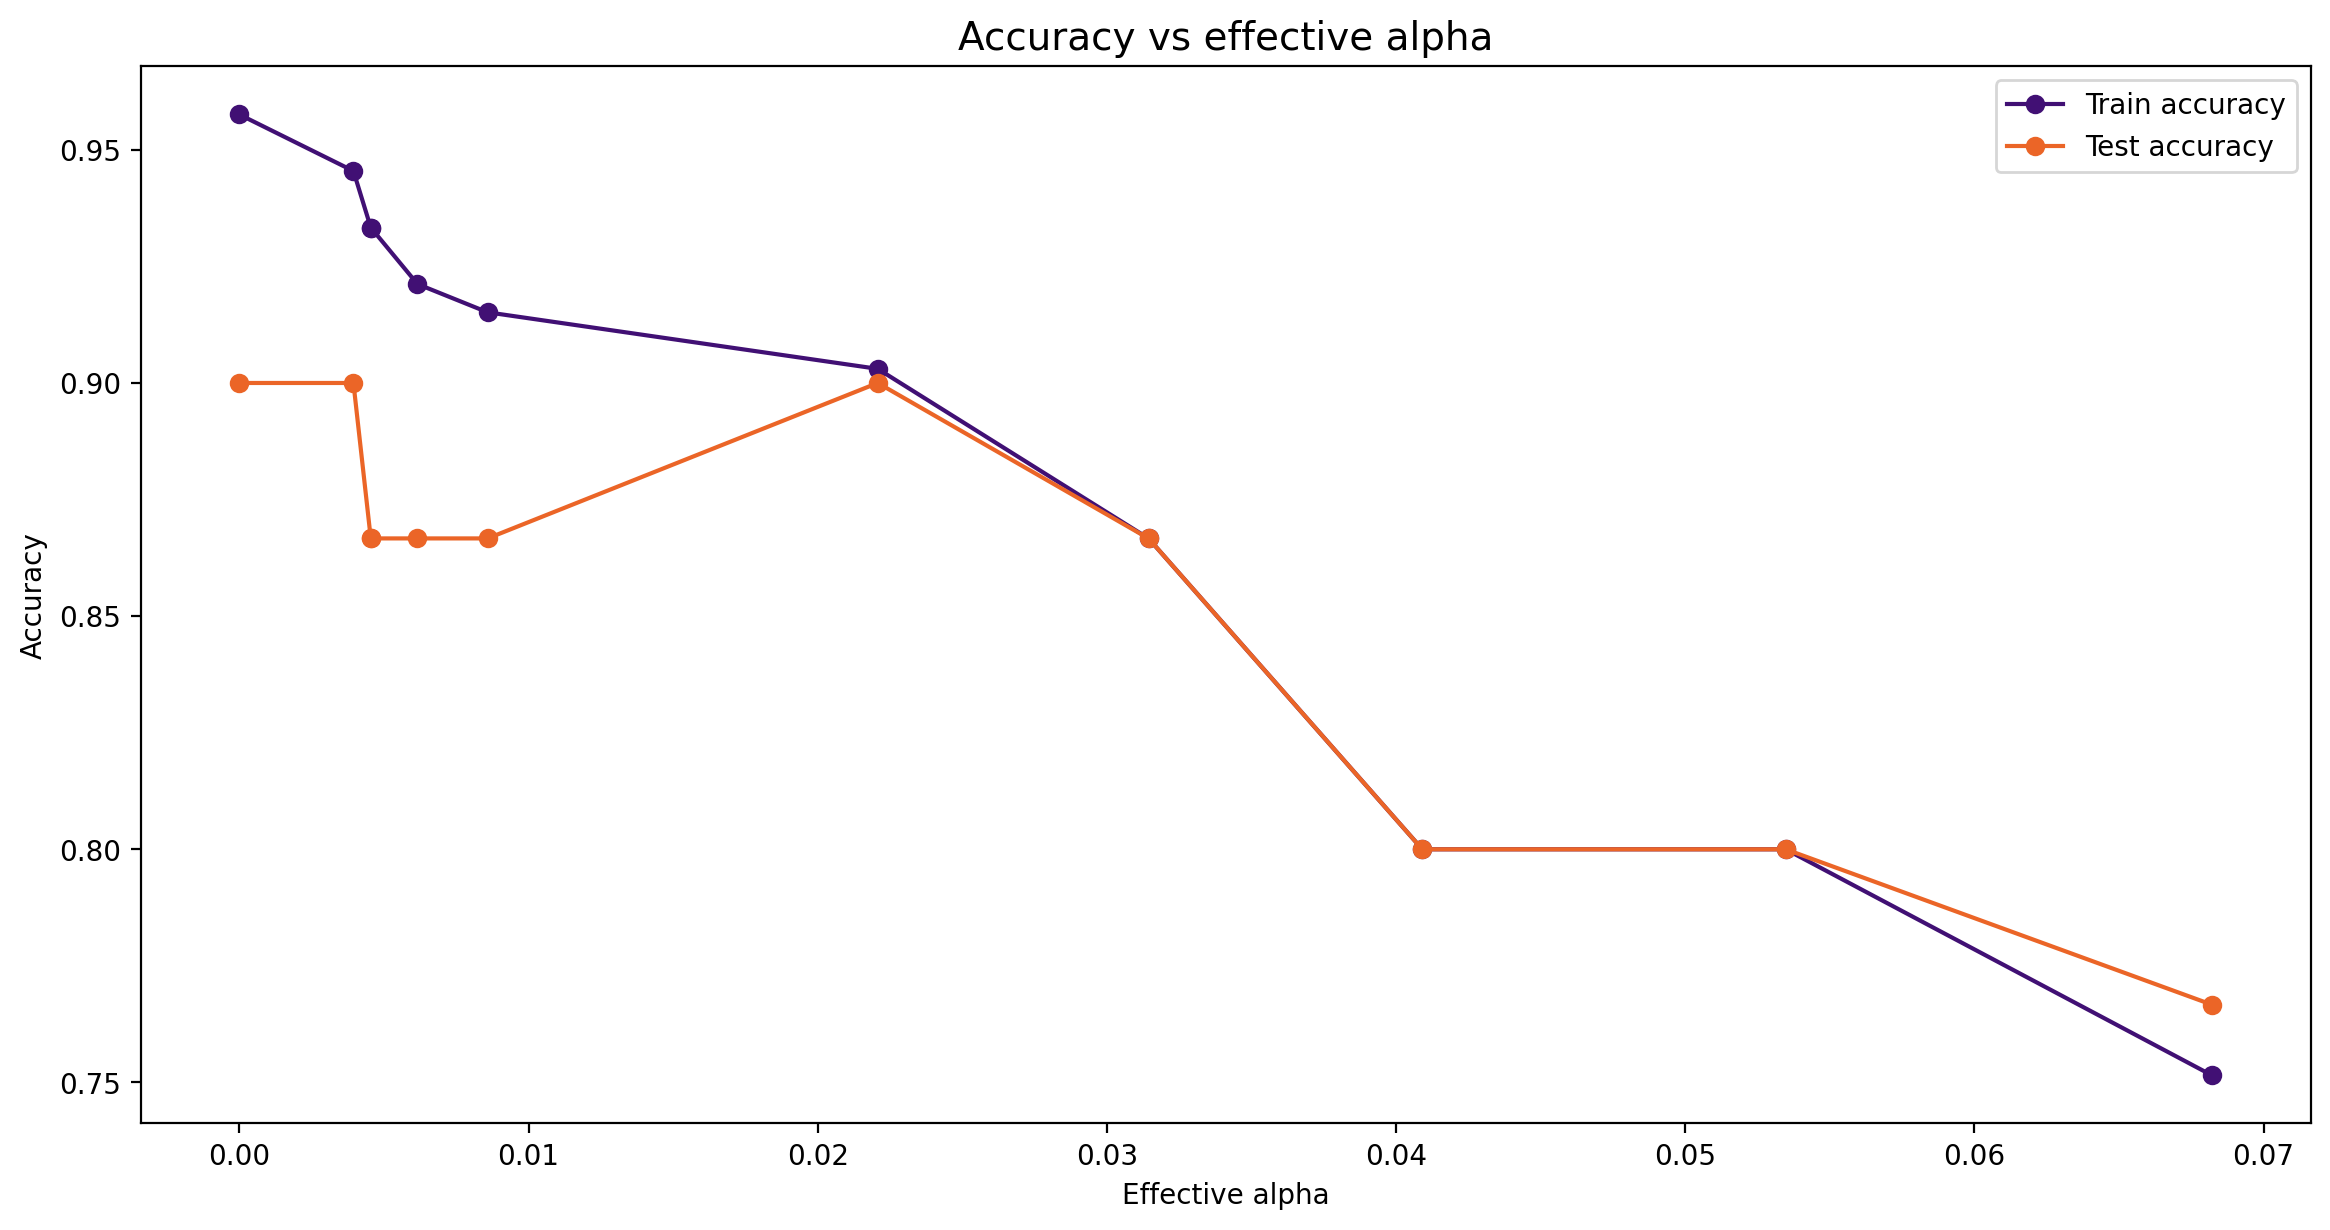

In [85]:
training_score = [classifier.score(X_train, y_train) for classifier in classifiers]
testing_score = [classifier.score(X_test,y_test) for classifier in classifiers]

plt.figure(dpi=200, figsize=(14,7))
plt.plot(ccp_alphas, training_score, color="#411074", marker="o", label="Train accuracy")
plt.plot(ccp_alphas, testing_score, color="#eb6527", marker="o", label="Test accuracy")
plt.xlabel("Effective alpha")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Accuracy vs effective alpha", fontsize=14)

In [107]:
# Final decision tree
# Selected the one giving the highest test set accuracy score and being closest to train set accuracy score (which is still high)

final_tree = classifiers[6]
final_tree

DecisionTreeClassifier(ccp_alpha=0.022077922077922085, max_depth=6,
                       max_features=1, random_state=1)

In [108]:
final_tree.fit(X_train, y_train)
final_tree.predict(X_test)

final_score = final_tree.score(X_test,y_test)
final_score

0.9